In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers import RNN
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers import LSTM

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

Using TensorFlow backend.


## Read in Data

In [2]:
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000]
e_train = df.iloc[20000:]

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
# LAE: added .values before reshape due to pandas naming deprecation
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Create and Train Model

In [3]:
def train_model(x, y, LSTM_units=10, layers=3, dense_nodes=20,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    
    model = Sequential()
    
    # LSTM recurrent layers
    model.add(LSTM(LSTM_units,input_shape=(50,4),return_sequences=True)) # 50 "time steps", 4 features (one-hot ATGC encode)
    model.add(Dropout(dropout1))
    model.add(LSTM(LSTM_units,input_shape=(50,4)))
    
    # fully-connected linear layer
    model.add(Dense(dense_nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    # final linear classifier
    model.add(Dense(1))
    model.add(Activation('linear'))
    
    
    # Compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model

In [4]:
# Load Model 
model = keras.models.load_model('./saved_models/rnn_model_120u3e.hdf5')
small_model = keras.models.load_model('./saved_models/rnn_model_40u3e.hdf5')
small_model_10e = keras.models.load_model('./saved_models/rnn_model_40u10e.hdf5')
tiny_model = keras.models.load_model('./saved_models/rnn_model_10u3e.hdf5')
tiny_model_10e = keras.models.load_model('./saved_models/rnn_model_10u10e.hdf5')

W0903 16:17:24.475116 4524893632 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 16:17:24.498769 4524893632 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 16:17:24.503201 4524893632 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 16:17:24.925365 4524893632 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0903 16:17:24.926881 4524893632 deprecation_wrapper

In [5]:
# np.random.seed(1337)
# model = train_model(seq_e_train,e_train['scaled_rl'], LSTM_units=120, dense_nodes=40, nb_epoch=3)

W0903 14:06:26.157857 4588709312 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 14:06:26.178179 4588709312 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 14:06:26.181520 4588709312 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 14:06:26.546263 4588709312 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0903 14:06:26.748498 4588709312 deprecation.py:323] From /usr/local/lib/pyt

Epoch 1/3
260000/260000 [==============================] - 351s 1ms/step - loss: 0.7672 - acc: 0.0000e+00
Epoch 2/3
260000/260000 [==============================] - 317s 1ms/step - loss: 0.3281 - acc: 0.0000e+00
Epoch 3/3
260000/260000 [==============================] - 314s 1ms/step - loss: 0.2083 - acc: 0.0000e+00


In [7]:
# np.random.seed(1337)
# small_model = train_model(seq_e_train,e_train['scaled_rl'], LSTM_units=40, dense_nodes=40, nb_epoch=3)

Epoch 1/3
260000/260000 [==============================] - 159s 613us/step - loss: 0.6531 - acc: 0.0000e+00
Epoch 2/3
260000/260000 [==============================] - 158s 609us/step - loss: 0.3076 - acc: 0.0000e+00
Epoch 3/3
260000/260000 [==============================] - 159s 611us/step - loss: 0.2645 - acc: 0.0000e+00


In [8]:
# np.random.seed(1337)
# small_model_10e = train_model(seq_e_train,e_train['scaled_rl'], LSTM_units=40, dense_nodes=40, nb_epoch=10)

Epoch 1/10
260000/260000 [==============================] - 168s 644us/step - loss: 0.6753 - acc: 0.0000e+00
Epoch 2/10
260000/260000 [==============================] - 161s 619us/step - loss: 0.2618 - acc: 0.0000e+00
Epoch 3/10
260000/260000 [==============================] - 159s 612us/step - loss: 0.1923 - acc: 0.0000e+00
Epoch 4/10
260000/260000 [==============================] - 160s 613us/step - loss: 0.1553 - acc: 0.0000e+00
Epoch 5/10
260000/260000 [==============================] - 159s 613us/step - loss: 0.1356 - acc: 0.0000e+00
Epoch 6/10
260000/260000 [==============================] - 160s 615us/step - loss: 0.1280 - acc: 0.0000e+00
Epoch 7/10
260000/260000 [==============================] - 159s 613us/step - loss: 0.1227 - acc: 0.0000e+00
Epoch 8/10
260000/260000 [==============================] - 159s 612us/step - loss: 0.1204 - acc: 0.0000e+00
Epoch 9/10
260000/260000 [==============================] - 159s 613us/step - loss: 0.1160 - acc: 0.0000e+00
Epoch 10/10
260000/

In [10]:
# np.random.seed(1337)
# tiny_model = train_model(seq_e_train,e_train['scaled_rl'], LSTM_units=10, dense_nodes=40, nb_epoch=3)

Epoch 1/3
260000/260000 [==============================] - 153s 587us/step - loss: 0.8650 - acc: 0.0000e+00
Epoch 2/3
260000/260000 [==============================] - 149s 571us/step - loss: 0.5102 - acc: 0.0000e+00
Epoch 3/3
260000/260000 [==============================] - 148s 570us/step - loss: 0.4798 - acc: 0.0000e+00


In [12]:
# np.random.seed(1337)
# tiny_model_10e = train_model(seq_e_train,e_train['scaled_rl'], LSTM_units=10, dense_nodes=40, nb_epoch=10)

Epoch 1/10
260000/260000 [==============================] - 153s 588us/step - loss: 0.8646 - acc: 0.0000e+00
Epoch 2/10
260000/260000 [==============================] - 149s 574us/step - loss: 0.5097 - acc: 0.0000e+00
Epoch 3/10
260000/260000 [==============================] - 150s 578us/step - loss: 0.4792 - acc: 0.0000e+00
Epoch 4/10
260000/260000 [==============================] - 150s 576us/step - loss: 0.4594 - acc: 0.0000e+00
Epoch 5/10
260000/260000 [==============================] - 149s 571us/step - loss: 0.4467 - acc: 0.0000e+00
Epoch 6/10
260000/260000 [==============================] - 150s 575us/step - loss: 0.4395 - acc: 0.0000e+00
Epoch 7/10
260000/260000 [==============================] - 151s 580us/step - loss: 0.4335 - acc: 0.0000e+00
Epoch 8/10
260000/260000 [==============================] - 150s 578us/step - loss: 0.4299 - acc: 0.0000e+00
Epoch 9/10
260000/260000 [==============================] - 149s 572us/step - loss: 0.4268 - acc: 0.0000e+00
Epoch 10/10
260000/

In [8]:
e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print 'r-squared = ', r

r-squared =  0.8944632971164274


In [9]:
e_test = test_data(df=e_test, model=small_model, obs_col='rl',test_seq=seq_e_test,output_col='small_3e_pred')
r = r2(e_test['rl'], e_test['small_3e_pred'])
print 'r-squared = ', r

r-squared =  0.8371920697799942


In [10]:
e_test = test_data(df=e_test, model=small_model_10e, obs_col='rl',test_seq=seq_e_test,output_col='small_10e_pred')
r = r2(e_test['rl'], e_test['small_10e_pred'])
print 'r-squared = ', r

r-squared =  0.9384655591255765


In [11]:
e_test = test_data(df=e_test, model=tiny_model, obs_col='rl',test_seq=seq_e_test,output_col='tiny_3e_pred')
r = r2(e_test['rl'], e_test['tiny_3e_pred'])
print 'r-squared = ', r

r-squared =  0.6338874547929109


In [12]:
e_test = test_data(df=e_test, model=tiny_model_10e, obs_col='rl',test_seq=seq_e_test,output_col='tiny_10e_pred')
r = r2(e_test['rl'], e_test['tiny_10e_pred'])
print 'r-squared = ', r

r-squared =  0.6736790306395483


In [20]:
# Save Model
# model.save('./saved_models/rnn_model_120u3e.hdf5')
# small_model.save('./saved_models/rnn_model_40u3e.hdf5')
# small_model_10e.save('./saved_models/rnn_model_40u10e.hdf5')
# tiny_model.save('./saved_models/rnn_model_10u3e.hdf5')
# tiny_model_10e.save('./saved_models/rnn_model_10u10e.hdf5')

## Plotting Results

In [5]:
# Compute model performance on the TRAIN set, too, so we can compare!
# Note: this takes a while
e_train = test_data(df=e_train, model=model, obs_col='rl',test_seq=seq_e_train, output_col='pred')
print 'done 120u3e'
e_train = test_data(df=e_train, model=small_model, obs_col='rl',test_seq=seq_e_train, output_col='40u3e_pred')
print 'done 40u3e'
e_train = test_data(df=e_train, model=small_model_10e, obs_col='rl',test_seq=seq_e_train, output_col='40u10e_pred')
print 'done 40u10e'
e_train = test_data(df=e_train, model=tiny_model, obs_col='rl',test_seq=seq_e_train, output_col='10u3e_pred')
print 'done 10u3e'
e_train = test_data(df=e_train, model=tiny_model_10e, obs_col='rl',test_seq=seq_e_train, output_col='10u10e_pred')
print 'done 10u10e'

In [6]:
print '120 units, 3 epochs TRAIN r-squared = ', r2(e_train['rl'], e_train['pred'])
print '40 units, 3 epochs TRAIN r-squared = ', r2(e_train['rl'], e_train['40u3e_pred'])
print '40 units, 10 epochs TRAIN r-squared = ', r2(e_train['rl'], e_train['40u10e_pred'])
print '10 units, 3 epochs TRAIN r-squared = ', r2(e_train['rl'], e_train['10u3e_pred'])
print '10 units, 10 epochs TRAIN r-squared = ', r2(e_train['rl'], e_train['10u10e_pred'])

120 units, 3 epochs TRAIN r-squared =  0.8378043313108257
40 units, 3 epochs TRAIN r-squared =  0.7645868072693793
40 units, 10 epochs TRAIN r-squared =  0.8902948629423852
10 units, 3 epochs TRAIN r-squared =  0.5317135793588348
10 units, 10 epochs TRAIN r-squared =  0.5805875801263366


120 unit 3 epochs Model


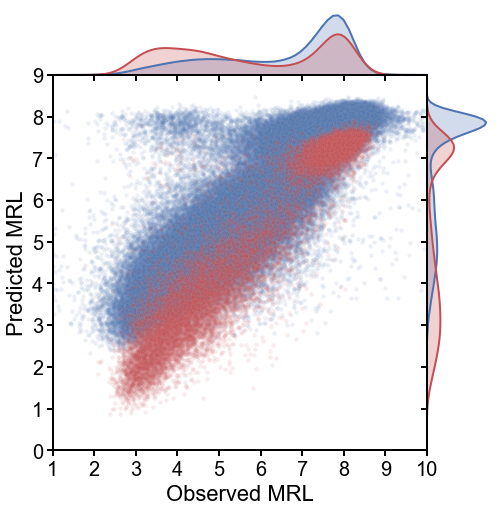

In [34]:
# Visualize results, colored by TRAIN/TEST (train=blue, Test=red)
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='rl', y="pred", data=e_train, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha='0.1', edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(0,9.01, 1));
ax.set_yticklabels(range(10),size=20);
ax.set_xticks(np.arange(1,10.01, 1));
ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(0,9)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = e_test['rl'].values
g.y = e_test['pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha='0.1', color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig
print "120 unit 3 epochs Model"

Most successful model (40 units 10 epochs)


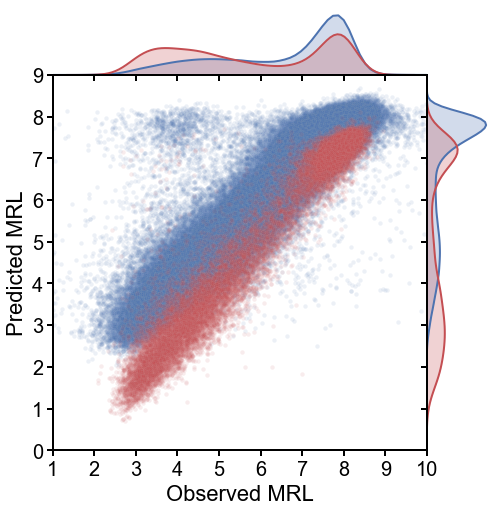

In [37]:
# Visualize results, colored by TRAIN/TEST (train=blue, Test=red)
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='rl', y="40u10e_pred", data=e_train, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha='0.1', edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(0,9.01, 1));
ax.set_yticklabels(range(10),size=20);
ax.set_xticks(np.arange(1,10.01, 1));
ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(0,9)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = e_test['rl'].values
g.y = e_test['small_10e_pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha='0.1', color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig
print "Most successful model (40 units 10 epochs)"

Least successful model (10 units 3 epochs)


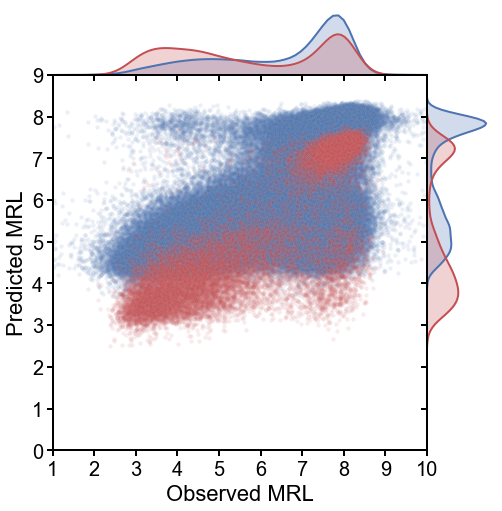

In [38]:
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='rl', y="10u3e_pred", data=e_train, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha='0.1', edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(0,9.01, 1));
ax.set_yticklabels(range(10),size=20);
ax.set_xticks(np.arange(1,10.01, 1));
ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(0,9)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = e_test['rl'].values
g.y = e_test['tiny_3e_pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha='0.1', color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig
print "Least successful model (10 units 3 epochs)"

### Observation: in the 120unit LSTM, the off-diagonal cluster in the TEST set is almost all gone! 

This is despite the fact that the overall R2 is less good (0.89 vs 0.94), which seems notable and interesting. Also, the off-diagonals in the TRAIN set are still there, seemingly unchanged, which would support the hypothesis that these are bad data rather than an otherwise unique class of sequences? Likewise, that in the least succesful model, the familiar cluster doesn't increase much in population but rather ANOTHER off-diagonal cluster (on the opposite diagonal) appears, makes it seem like there may be something consistent and non-content-based going on with the top cluster

In [13]:
# Examine that same region of the graph to see what has happened to the off-diagonal cluster
od_train = e_train[((e_train['pred']-e_train['rl'])**2 > 3.5)
                   &(e_train['pred']-e_train['rl'] > 0)&(e_train['pred'] > 6.5)] 
od_test = e_test[((e_test['pred']-e_test['rl'])**2 > 3.5)
                   &(e_test['pred']-e_test['rl'] > 0)&(e_test['pred'] > 6.5)] 
print "largest:", len(od_train), len(od_test)
print
od_train_best = e_train[((e_train['40u10e_pred']-e_train['rl'])**2 > 3.5)
                   &(e_train['40u10e_pred']-e_train['rl'] > 0)&(e_train['40u10e_pred'] > 6.5)] 
od_test_best = e_test[((e_test['small_10e_pred']-e_test['rl'])**2 > 3.5)
                   &(e_test['small_10e_pred']-e_test['rl'] > 0)&(e_test['small_10e_pred'] > 6.5)] 
print "most successful", len(od_train_best), len(od_test_best)
print
od_train_worst = e_train[((e_train['10u3e_pred']-e_train['rl'])**2 > 3.5)
                   &(e_train['10u3e_pred']-e_train['rl'] > 0)&(e_train['10u3e_pred'] > 6.5)] 
od_test_worst = e_test[((e_test['tiny_3e_pred']-e_test['rl'])**2 > 3.5)
                   &(e_test['tiny_3e_pred']-e_test['rl'] > 0)&(e_test['tiny_3e_pred'] > 6.5)] 
print "least successful", len(od_train_worst), len(od_test_worst)

largest: 2210 61

most successful 1331 39

least successful 1964 38


In [14]:
trainl,testl = set(od_train['utr'].values),set(od_test['utr'].values)
trainb,testb = set(od_train_best['utr'].values),set(od_test_best['utr'].values)
trainw,testw = set(od_train_worst['utr'].values),set(od_test_worst['utr'].values)

In [15]:
print "Overlap between best and worst model TEST set ODs:"
print "\t", len(testb.difference(testw)), "in best model only"
print "\t", len(testb.intersection(testw)), "Shared"
print "\t", len(testw.difference(testb)), "in worst model only"

Overlap between best and worst model TEST set ODs:
	10 in best model only
	29 Shared
	9 in worst model only


In [16]:
print "Overlap between best and worst model TRAIN set ODs:"
print "\t", len(trainb.difference(trainw)), "in best model only"
print "\t", len(trainb.intersection(trainw)), "Shared"
print "\t", len(trainw.difference(trainb)), "in worst model only"

Overlap between best and worst model TRAIN set ODs:
	316 in best model only
	1015 Shared
	949 in worst model only


In [17]:
print "Overlap between best and Longest model TEST set ODs:"
print "\t", len(testb.difference(testl)), "in best model only"
print "\t", len(testb.intersection(testl)), "Shared"
print "\t", len(testl.difference(testb)), "in 120u model only"

Overlap between best and Longest model TEST set ODs:
	1 in best model only
	38 Shared
	23 in 120u model only


Ah, hmm, so it looks like the best model ODs in the train set are essentially just a subset of the 120u model, but the really small model (10u3e) makes some more unique mistakes. Interesting

In [18]:
print "Overlap between best and Longest model TRAIN set ODs:"
print "\t", len(trainb.difference(trainl)), "in best model only"
print "\t", len(trainb.intersection(trainl)), "Shared"
print "\t", len(trainl.difference(trainb)), "in 120u model only"

Overlap between best and Longest model TRAIN set ODs:
	51 in best model only
	1280 Shared
	930 in 120u model only


Again, mostly (although not completely), 40u10e off-diagonal cluster is just a subset of the 120u3e off-diagonal cluster

In [22]:
e_train = e_train.drop(columns=['Unnamed: 0'])
e_test = e_test.drop(columns=['Unnamed: 0'])

In [25]:
# Save Data
# e_train[e_train['utr'].isin(trainl)].to_csv('./saved_data/off_diagonal_cluster/RNN_120u3e_train_od.csv')
# e_test[e_test['utr'].isin(testl)].to_csv('./saved_data/off_diagonal_cluster/RNN_120u3e_test_od.csv')
# e_train[e_train['utr'].isin(trainb)].to_csv('./saved_data/off_diagonal_cluster/RNN_40u10e_train_od.csv')
# e_test[e_test['utr'].isin(testb)].to_csv('./saved_data/off_diagonal_cluster/RNN_40u10e_test_od.csv')
# e_train[e_train['utr'].isin(trainw)].to_csv('./saved_data/off_diagonal_cluster/RNN_10u3e_train_od.csv')
# e_test[e_test['utr'].isin(testw)].to_csv('./saved_data/off_diagonal_cluster/RNN_10u3e_test_od.csv')